In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import seaborn as sns

In [2]:
# Impostazioni
RANDOM_STATE = 17
N_CLASSES = 20
IMG_SIZE = (224, 224, 3)
BATCH_SIZE = 128
EPOCHS = 40

STEPS_PER_EPOCH = 9232 // BATCH_SIZE
VALIDATION_STEPS = 1154 // BATCH_SIZE
TEST_STEPS = 1154 // BATCH_SIZE

In [3]:
# Impostiamo i semi per la riproducibilità
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
keras.utils.set_random_seed(RANDOM_STATE)

In [4]:
# Montiamo Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ROOT_DIR = 'drive/MyDrive/AdvanceMachineLearning/ProgettoFinale/'
IMAGE_ZIP = ROOT_DIR + "project/dataset/images.zip"
IMG_EXTRACT_DIR = "content/dataset/"
ANNOTATIONS_DATASET = ROOT_DIR + 'project/dataset/annotations/'

# Percorsi immagini
IMG_DIR = IMG_EXTRACT_DIR + 'images/'
TRAIN_IMAGE_DIR = IMG_DIR + 'train/'
VALIDATION_IMAGE_DIR = IMG_DIR + 'validation/'
TEST_IMAGE_DIR = IMG_DIR + 'test/'

Mounted at /content/drive


In [5]:
# Estrai il file ZIP se necessario
os.makedirs(IMG_EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(IMAGE_ZIP, 'r') as zip_ref:
    zip_ref.extractall(IMG_EXTRACT_DIR)

In [6]:
# Caricamento etichette
CLASSES = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
classes_map = {c: i for i, c in enumerate(CLASSES)}

In [7]:
# Funzioni di preprocessing
def load_csv(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    file_paths = df['file'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")).tolist()
    classes_ids = df['classes_id'].apply(lambda x: eval(x))
    return file_paths, classes_ids

def vector_encoding(labels, num_classes):
    class_vector = tf.zeros(num_classes, dtype=tf.float32)
    for label in labels:
        class_vector = tf.tensor_scatter_nd_update(class_vector, [[label - 1]], [1])
    return class_vector

def preprocess_image(image_path, preprocess_fn, resize=IMG_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, resize[:2])
    return preprocess_fn(image)

def create_tf_dataset(csv_path, image_dir, preprocess_fn=lambda x: x, batch_size=BATCH_SIZE, resize=IMG_SIZE, num_classes=N_CLASSES):
    image_paths, label_ids = load_csv(csv_path, image_dir)
    label_ids = [vector_encoding(labels, num_classes) for labels in label_ids]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

    def load_and_preprocess(image_path, labels):
        image = preprocess_image(image_path, preprocess_fn, resize)
        return image, labels

    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

# Funzioni di visualizzazione
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(num_images):
            plt.subplot(1, num_images, j + 1)
            plt.imshow(images[j].numpy().astype("uint8"))
            label_indices = np.where(labels[j].numpy() > 0.5)[0]
            label_names = [CLASSES[i] for i in label_indices]
            plt.title("\n".join(label_names))
            plt.axis("off")
    plt.show()

In [8]:
# Caricamento dataset
train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR)
validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR)
test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR)

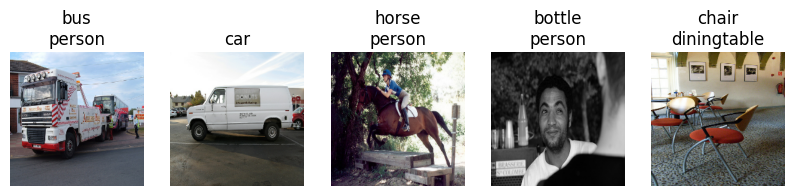

In [9]:
# Mostra alcune immagini di esempio
show_sample_images(train_dataset)

In [10]:
@tf.keras.utils.register_keras_serializable()
def perfect_accuracy(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.uint8)
    y_pred_bin = tf.cast(y_pred >= threshold, tf.uint8)
    correct_predictions = tf.reduce_all(tf.equal(y_true, y_pred_bin), axis=1)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

map_metric = tf.keras.metrics.AUC(
    curve='PR', multi_label=True, name='mAP')

f1_score = tf.keras.metrics.F1Score(
    average='weighted', threshold=None, name='f1_score', dtype=None
)

binary_accuracy = tf.keras.metrics.BinaryAccuracy(
    threshold=None, name='binary_accuracy', dtype=None
)

precision = tf.keras.metrics.Precision(thresholds=None, name='precision')
recall = tf.keras.metrics.Recall(thresholds=None, name='recall')

def build_model(model):
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[perfect_accuracy, map_metric, f1_score, precision, recall])
    model.summary()
    return model

In [11]:
def validate_model(model, validation_dataset, num_batches=VALIDATION_STEPS):
    validation_images = []
    encoded_validation_labels = []

    # Itera sui batch del dataset per raccogliere più dati
    for images, labels in validation_dataset.take(num_batches):
        validation_images.append(images.numpy())  # Converti tensori in numpy
        encoded_validation_labels.append(labels.numpy())

    # Concatena tutti i batch raccolti in un unico array
    validation_images = np.concatenate(validation_images, axis=0)
    encoded_validation_labels = np.concatenate(encoded_validation_labels, axis=0)

    # Predire le probabilità con il modello
    y_pred_probs = model.predict(validation_images)

    # Calcolare precision e recall per diverse soglie
    precisions, recalls, thresholds = precision_recall_curve(
        encoded_validation_labels.flatten(), y_pred_probs.flatten()
    )

    # Determinare la soglia migliore (massimizzando il prodotto precision * recall)
    best_threshold = thresholds[np.argmax(precisions * recalls / (precisions + recalls))]

    # Plot Precision-Recall vs. Threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], label="Precision", linestyle='--', marker='o')
    plt.plot(thresholds, recalls[:-1], label="Recall", linestyle='-', marker='s')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Best Threshold = {best_threshold:.4f}")

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision-Recall vs. Threshold")
    plt.legend()
    plt.grid()
    plt.show()

    return float(best_threshold)


In [12]:
# Costruzione modelli
def train_model(model, train_dataset, validation_dataset, epochs=EPOCHS):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, callbacks=[early_stopping])
    return history

# Funzione di plot della cronologia
def plot_history(history) -> None:
    metrics = list(history.history.keys())
    n_metrics = len([m for m in metrics if not m.startswith('val_')])
    n_cols = 2
    n_rows = (n_metrics + 1) // 2  # Arrotonda per eccesso
    fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.tight_layout(pad=3.0)

    if n_rows > 1:
        axis = axis.flatten()

    plot_index = 0
    base_metrics = [m for m in metrics if not m.startswith('val_')]

    for metric in base_metrics:
        val_metric = f'val_{metric}'
        if metric not in history.history:
            continue

        train_data = history.history[metric]
        val_data = history.history[val_metric] if val_metric in history.history else None
        if n_rows > 1:
            current_axis = axis[plot_index]
        else:
            current_axis = axis[plot_index] if n_cols > 1 else axis

        current_axis.set_title(f'{metric.capitalize()}')
        current_axis.set_xlabel('Epochs')
        current_axis.set_ylabel(metric.capitalize())

        current_axis.plot(train_data, label=f'Training {metric.capitalize()}')
        if val_data is not None:
            current_axis.plot(val_data, label=f'Validation {metric.capitalize()}')

        current_axis.legend()
        plot_index += 1

    while plot_index < len(axis):
        fig.delaxes(axis[plot_index])
        plot_index += 1

    plt.show()

In [13]:
def show_predictions(model, dataset, num_images=5, threshold=0.5):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        for i in range(num_images):
            predicted_indices = np.where(predictions[i] > threshold)[0]
            predicted_labels = [CLASSES[idx] for idx in predicted_indices]

            true_indices = np.where(labels[i].numpy() > 0.5)[0]
            true_labels = [CLASSES[idx] for idx in true_indices]

            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))

            title = f"Pred: {', '.join(predicted_labels)}\nTrue: {', '.join(true_labels)}"
            plt.title(title)

            plt.axis("off")
    plt.show()

# Valutazione
def evaluate_model(model, test_dataset, name, threshold, num_batches=TEST_STEPS):

    test_images = []
    encoded_test_labels = []

    # Itera sui batch del dataset per raccogliere più dati
    for images, labels in test_dataset.take(num_batches):
        test_images.append(images.numpy())  # Converti tensori in numpy
        encoded_test_labels.append(labels.numpy())

    # Concatena tutti i batch raccolti in un unico array
    test_images = np.concatenate(test_images, axis=0)
    encoded_test_labels = np.concatenate(encoded_test_labels, axis=0)

    predition = model.predict(test_images)

    prediction_binary = (predition > threshold).astype(int)

    binary_accuracy = tf.keras.metrics.BinaryAccuracy()
    binary_accuracy.update_state(encoded_test_labels, prediction_binary)
    binary_accuracy = binary_accuracy.result().numpy()

    map_m = tf.keras.metrics.AUC(curve='PR', multi_label=True, name='mAP')
    map_m.update_state(encoded_test_labels, predition)
    map_m = map_m.result().numpy()

    f1_score = tf.keras.metrics.F1Score(average='weighted', threshold=threshold, name='f1_score', dtype=None)
    f1_score.update_state(encoded_test_labels, prediction_binary)
    f1_score = f1_score.result().numpy()

    precision = tf.keras.metrics.Precision(thresholds=threshold, name='precision')
    precision.update_state(encoded_test_labels, prediction_binary)
    precision = precision.result().numpy()

    recall = tf.keras.metrics.Recall(thresholds=threshold, name='recall')
    recall.update_state(encoded_test_labels, prediction_binary)
    recall = recall.result().numpy()

    perfect_acc = perfect_accuracy(encoded_test_labels, prediction_binary)
    perfect_acc = perfect_acc.numpy()

    print(f"Model: {name}")
    print(f"Binary Accuracy: {binary_accuracy}")
    print(f"Perfect Accuracy: {perfect_acc}")
    print(f"mAP: {map_m}")
    print(f"F1 Score: {f1_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    show_predictions(model, test_dataset, threshold=threshold)

    return {
        'name': name,
        'binary_accuracy': binary_accuracy,
        'perfect_accuracy': perfect_acc,
        'map_metric': map_m,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall
    }

# ResNet50

In [14]:
# Caricamento dataset
resnet_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, resnet_preprocess_input)
resnet_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, resnet_preprocess_input)
resnet_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, resnet_preprocess_input)

## Base ResNet50

In [15]:
ResNet50(weights='imagenet', include_top=True).summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
resnet_base.trainable = False
model_base_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_base_resnet = build_model(model_base_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │          40,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,628,692 (90.14 MB)

 Trainable params: 40,980 (160.08 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
history_base_resnet = train_model(model_base_resnet, resnet_train_dataset, resnet_validation_dataset)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 72s 685ms/step - f1_score: 0.4105 - loss: 0.2285 - mAP: 0.2995 - perfect_accuracy: 0.2019 - precision: 0.4781 - recall: 0.3136 - val_f1_score: 0.7009 - val_loss: 0.0956 - val_mAP: 0.7712 - val_perfect_accuracy: 0.5460 - val_precision: 0.8750 - val_recall: 0.6770
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 584ms/step - f1_score: 0.7054 - loss: 0.0908 - mAP: 0.7768 - perfect_accuracy: 0.5372 - precision: 0.8542 - recall: 0.6742 - val_f1_score: 0.7192 - val_loss: 0.0844 - val_mAP: 0.8124 - val_perfect_accuracy: 0.5877 - val_precision: 0.8744 - val_recall: 0.7238
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 535ms/step - f1_score: 0.7269 - loss: 0.0765 - mAP: 0.8330 - perfect_accuracy: 0.6060 - precision: 0.8771 - recall: 0.7307 - val_f1_score: 0.7242 - val_loss: 0.0786 - val_mAP: 0.8250 - val_perfect_accuracy: 0.5972 - val_precision: 0.8768 - val_recall: 0.7360
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 565ms/step - f1_score: 0.7373 - loss: 0.0695 - mAP: 0.8

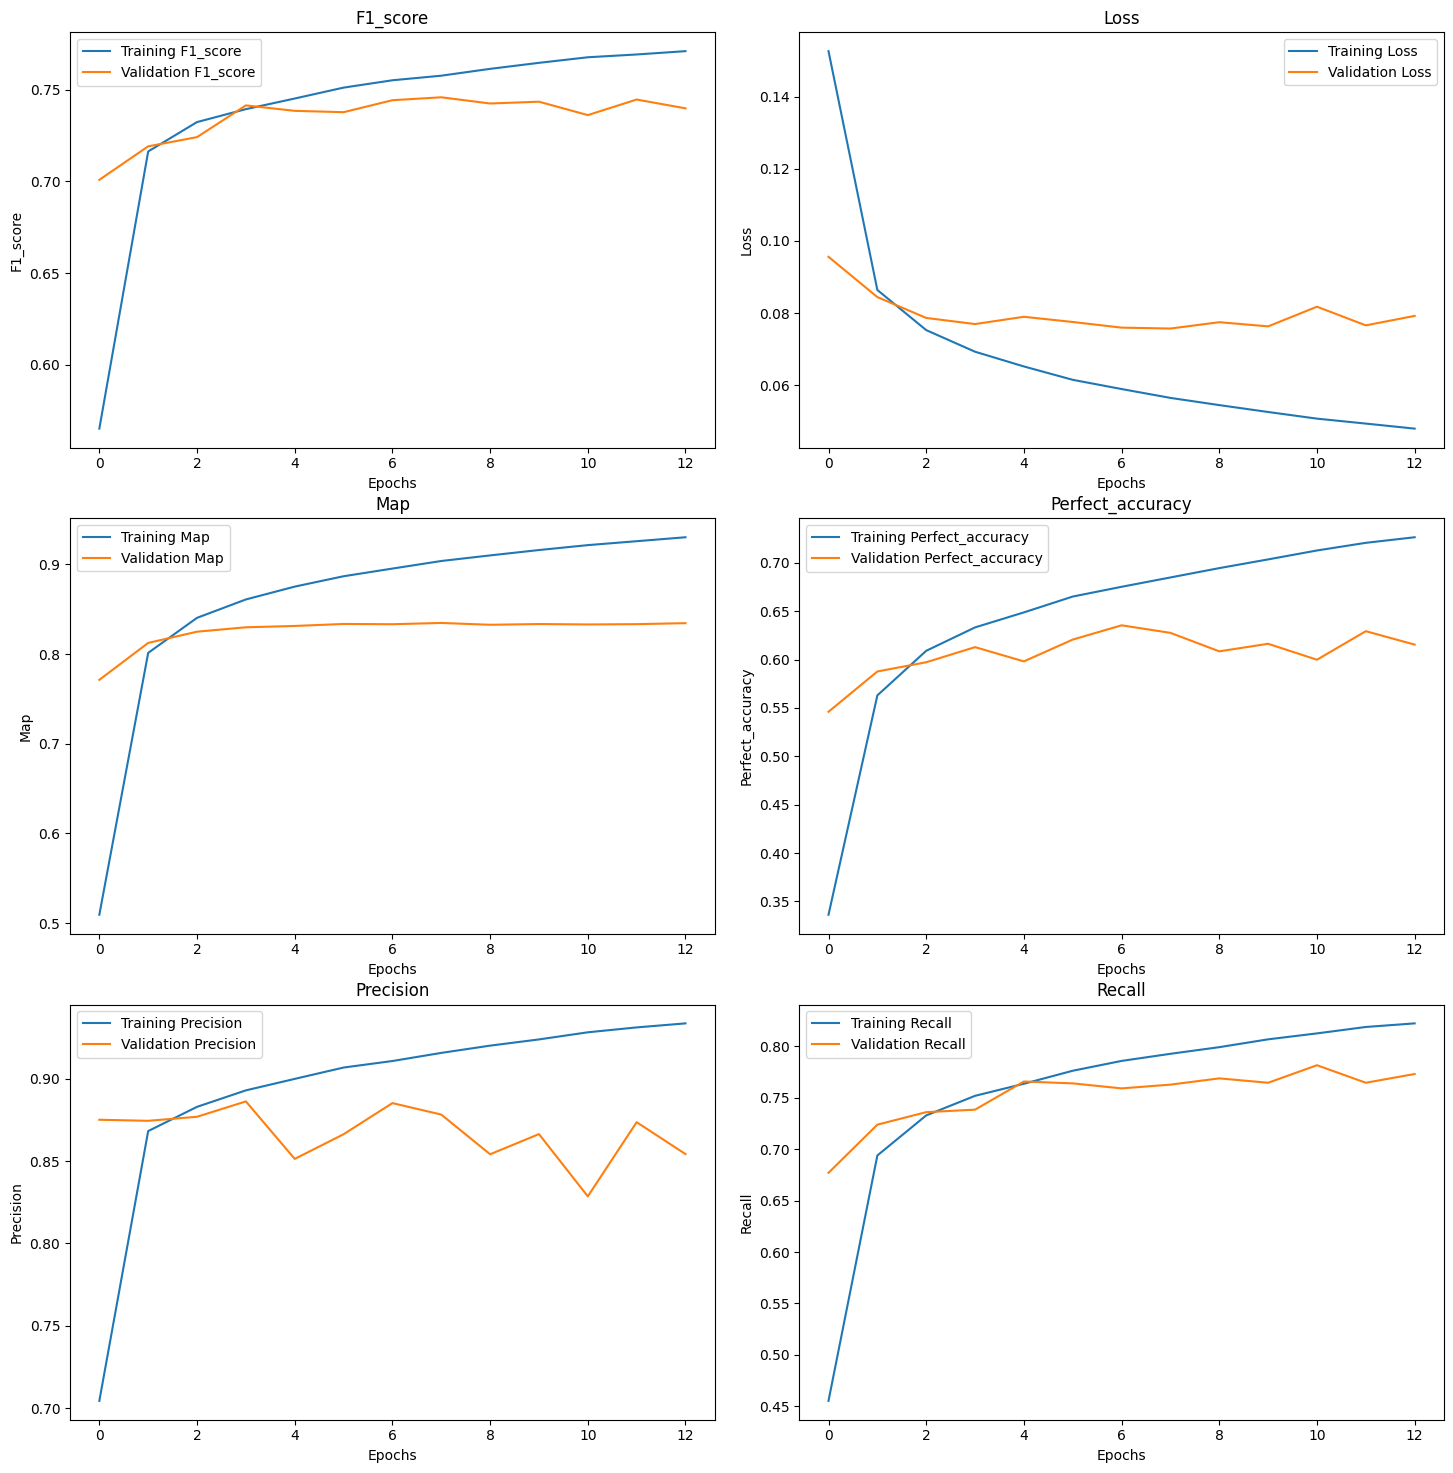

In [18]:
plot_history(history_base_resnet)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step


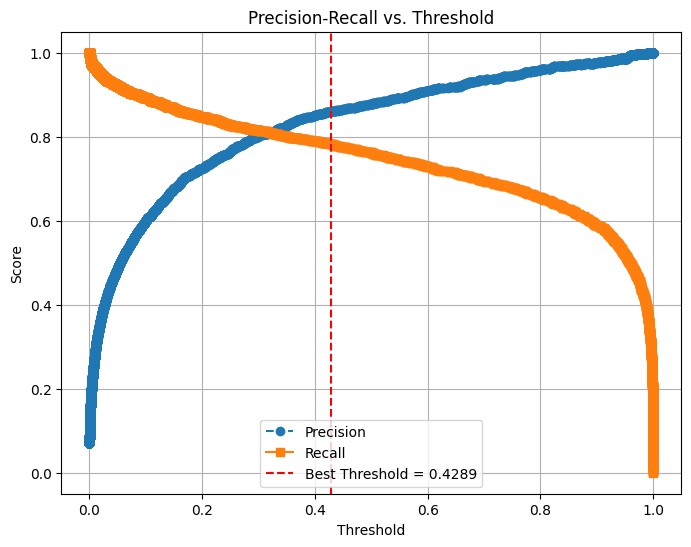

In [19]:
threshold_base_resnet = validate_model(model_base_resnet, resnet_validation_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step
Model: ResNet50
Binary Accuracy: 0.9723091125488281
Perfect Accuracy: 0.6032986044883728
mAP: 0.8408517837524414
F1 Score: 0.7926703691482544
Precision: 0.8467742204666138
Recall: 0.7544910311698914
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


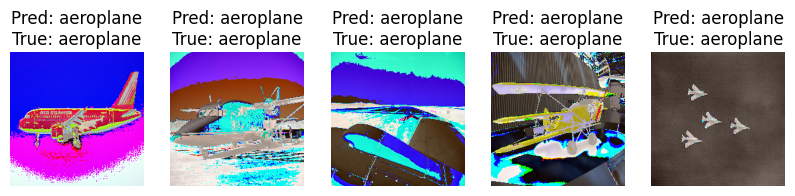

In [20]:
score_base_resnet = evaluate_model(model_base_resnet, resnet_test_dataset, "ResNet50", threshold_base_resnet)

In [21]:
model_base_resnet.save('model_base_resnet.keras')

## Fine Tuning ResNet50

In [22]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))

set_trainable = False
for layer in resnet_base.layers:
    if "conv5_block" in layer.name:
        set_trainable = True
    layer.trainable = set_trainable

model_ft_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_ft_resnet = build_model(model_ft_resnet)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │          40,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,628,692 (90.14 MB)

 Trainable params: 15,016,980 (57.29 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

In [23]:
history_ft_resnet = train_model(model_ft_resnet, resnet_train_dataset, resnet_validation_dataset)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 643ms/step - f1_score: 0.6598 - loss: 0.1608 - mAP: 0.6716 - perfect_accuracy: 0.4295 - precision: 0.7005 - recall: 0.6393 - val_f1_score: 0.7100 - val_loss: 0.0922 - val_mAP: 0.8252 - val_perfect_accuracy: 0.5720 - val_precision: 0.8092 - val_recall: 0.7530
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 77s 991ms/step - f1_score: 0.7608 - loss: 0.0528 - mAP: 0.9096 - perfect_accuracy: 0.7109 - precision: 0.9248 - recall: 0.8128 - val_f1_score: 0.7172 - val_loss: 0.0892 - val_mAP: 0.8361 - val_perfect_accuracy: 0.6059 - val_precision: 0.8440 - val_recall: 0.7470
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 568ms/step - f1_score: 0.7953 - loss: 0.0194 - mAP: 0.9862 - perfect_accuracy: 0.8953 - precision: 0.9829 - recall: 0.9307 - val_f1_score: 0.7273 - val_loss: 0.0976 - val_mAP: 0.8272 - val_perfect_accuracy: 0.6372 - val_precision: 0.8924 - val_recall: 0.7366
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - f1_score: 0.8021 - loss: 0.0066 - mAP: 0.9

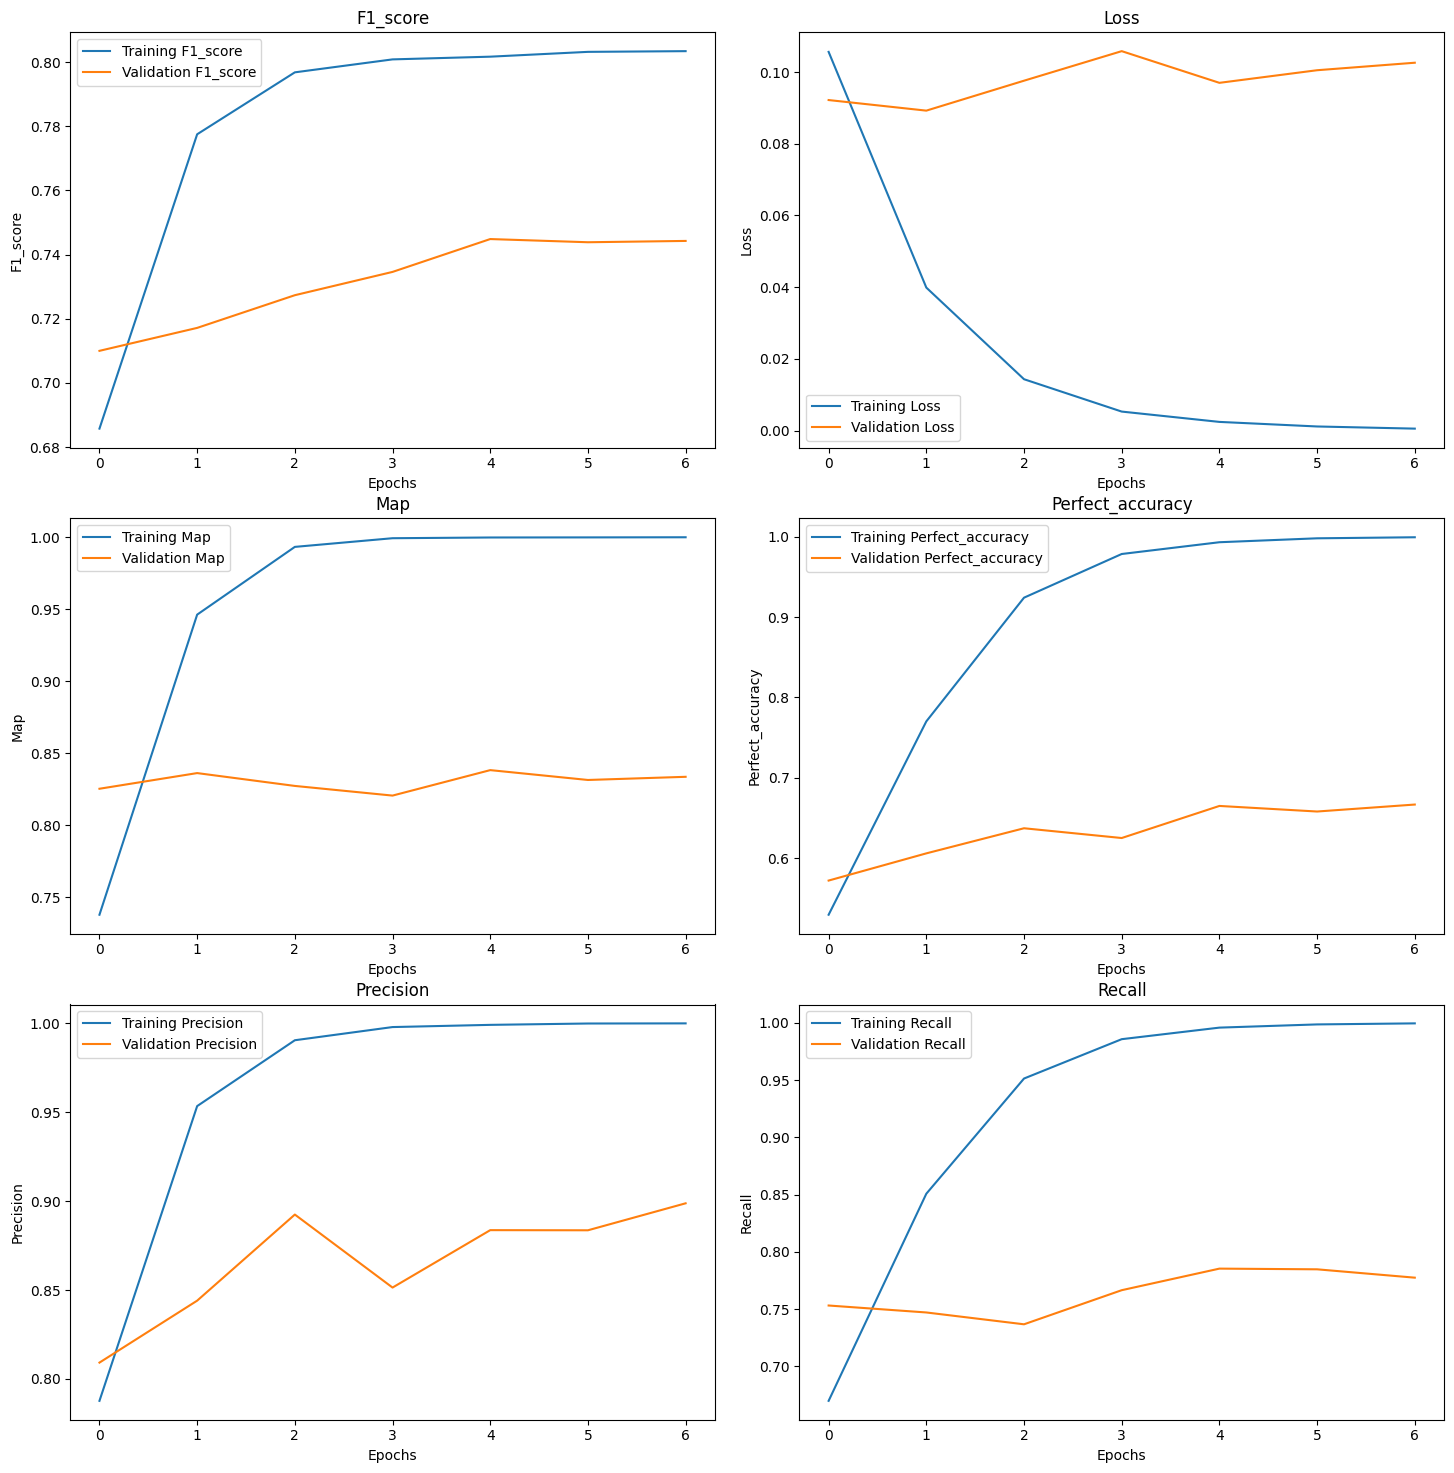

In [24]:
plot_history(history_ft_resnet)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step


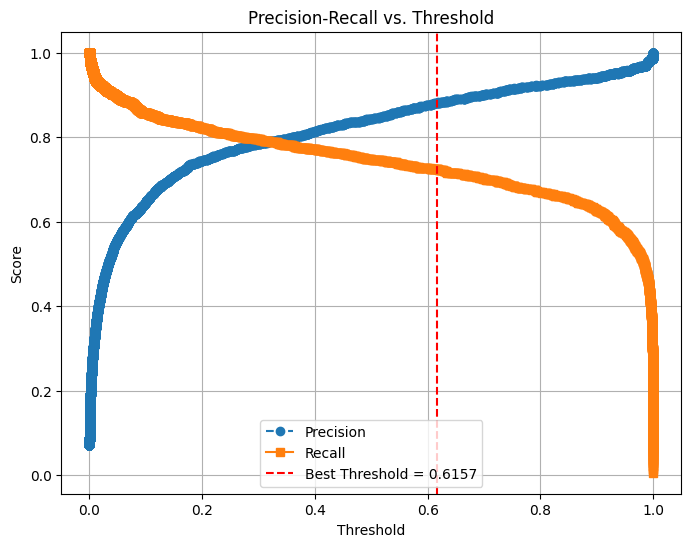

In [25]:
threshold_ft_resnet = validate_model(model_ft_resnet, resnet_validation_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step
Model: ResNet50 with Fine Tuning
Binary Accuracy: 0.9713541865348816
Perfect Accuracy: 0.5885416865348816
mAP: 0.8351743817329407
F1 Score: 0.7694875001907349
Precision: 0.8837385773658752
Recall: 0.6964071989059448
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


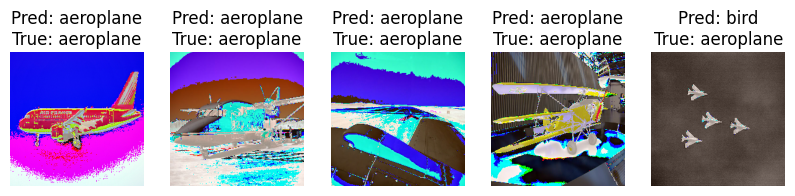

In [26]:
score_ft_resnet = evaluate_model(model_ft_resnet, resnet_test_dataset, "ResNet50 with Fine Tuning", threshold_ft_resnet)

In [27]:
model_ft_resnet.save('model_ft_resnet.keras')

# VGG16

In [28]:
vgg_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, vgg_preprocess_input)
vgg_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, vgg_preprocess_input)
vgg_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, vgg_preprocess_input)

In [29]:
VGG16(weights='imagenet', include_top=True).summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

## Base VGG16

In [30]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
vgg_base.trainable = False
model_base_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_base_vgg = build_model(model_base_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,799,444 (56.46 MB)

 Trainable params: 84,756 (331.08 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
history_base_vgg = train_model(model_base_vgg, vgg_train_dataset, vgg_validation_dataset)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 87s 680ms/step - f1_score: 0.5077 - loss: 0.3164 - mAP: 0.4458 - perfect_accuracy: 0.1971 - precision: 0.5425 - recall: 0.4930 - val_f1_score: 0.6572 - val_loss: 0.1097 - val_mAP: 0.7038 - val_perfect_accuracy: 0.4748 - val_precision: 0.8219 - val_recall: 0.6064
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 999ms/step - f1_score: 0.6598 - loss: 0.1067 - mAP: 0.7242 - perfect_accuracy: 0.4979 - precision: 0.8152 - recall: 0.6382 - val_f1_score: 0.6908 - val_loss: 0.0955 - val_mAP: 0.7567 - val_perfect_accuracy: 0.5217 - val_precision: 0.8398 - val_recall: 0.6697
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - f1_score: 0.7042 - loss: 0.0856 - mAP: 0.8032 - perfect_accuracy: 0.5694 - precision: 0.8542 - recall: 0.6973 - val_f1_score: 0.6967 - val_loss: 0.0926 - val_mAP: 0.7759 - val_perfect_accuracy: 0.5434 - val_precision: 0.8446 - val_recall: 0.6843
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 48s 662ms/step - f1_score: 0.7237 - loss: 0.0738 - mAP: 0.8425

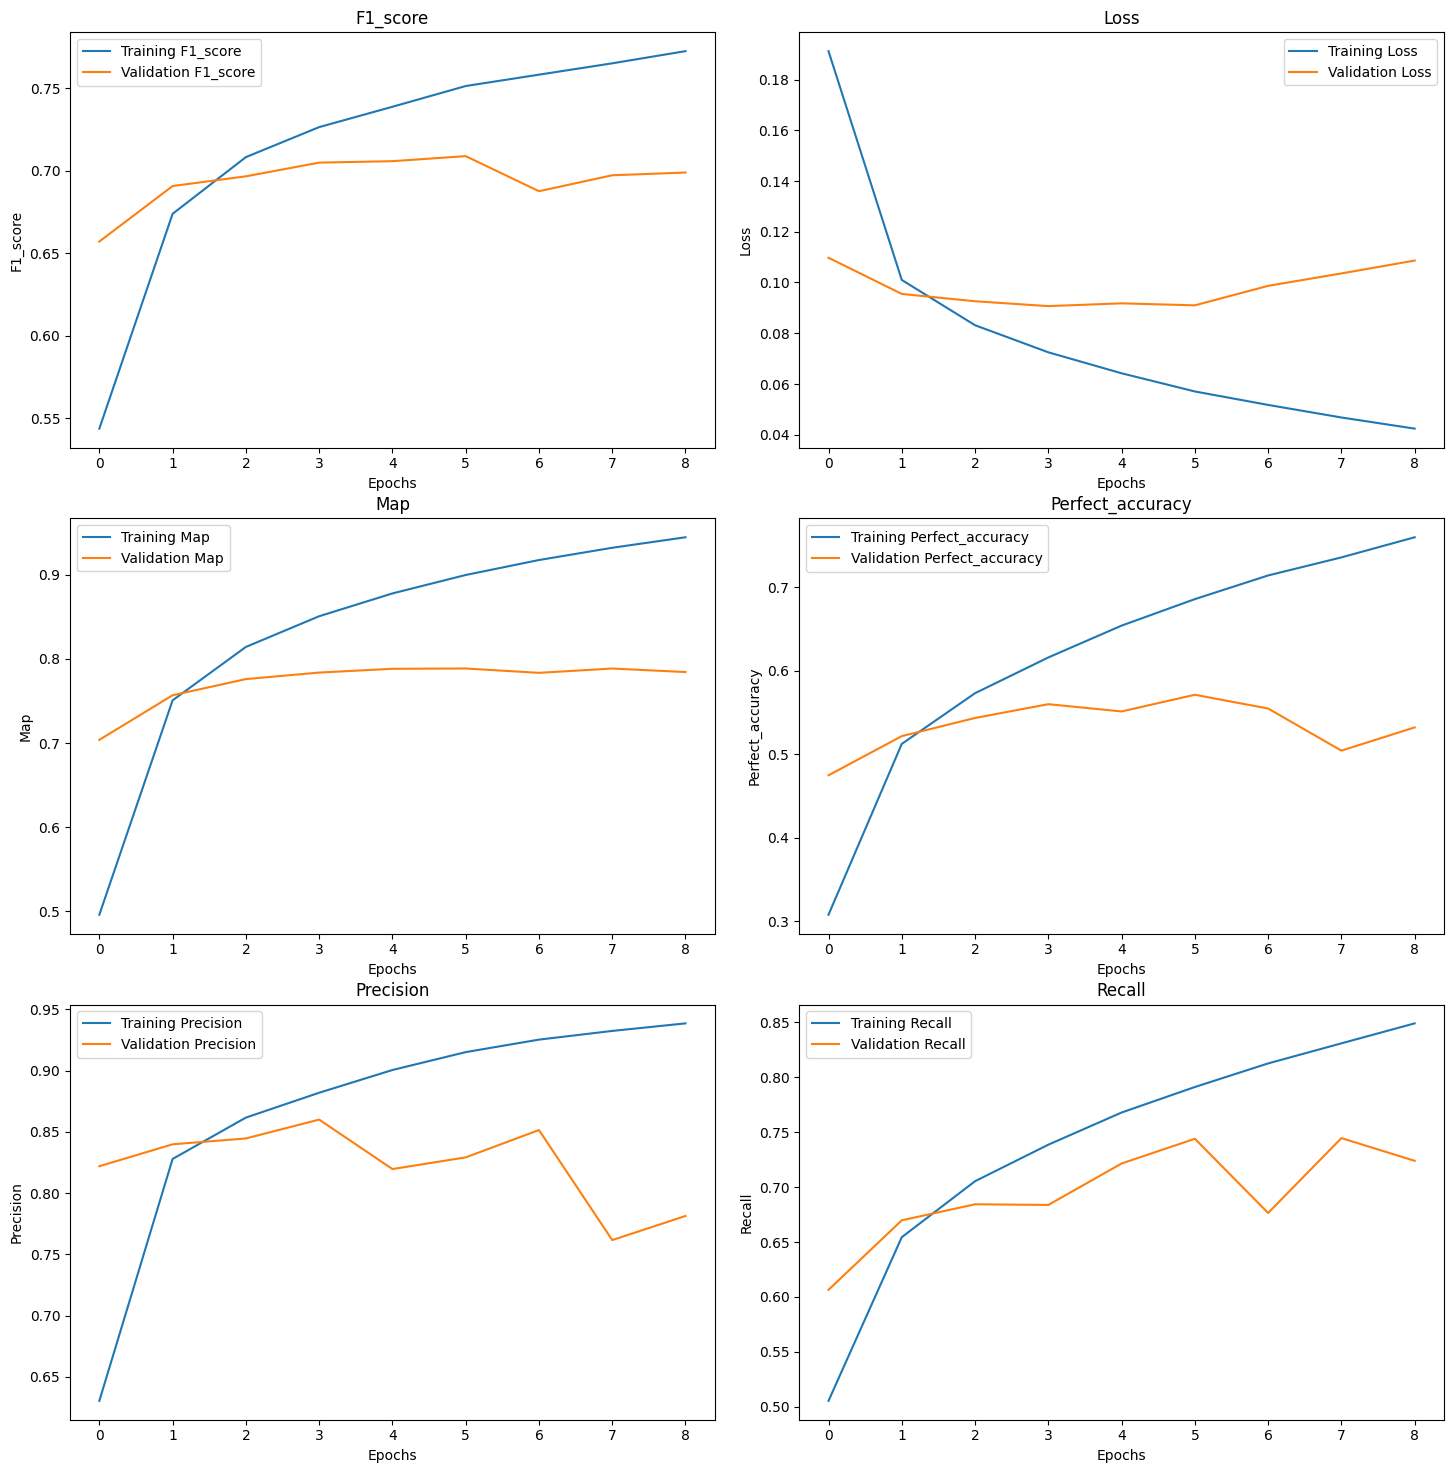

In [32]:
plot_history(history_base_vgg)

36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step


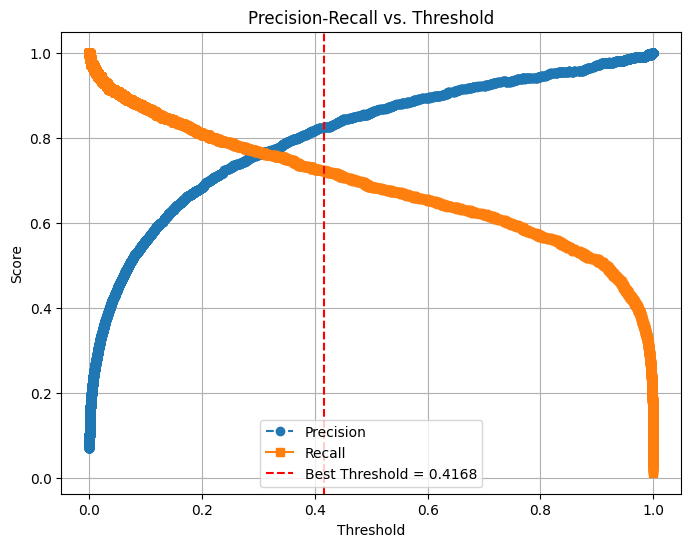

In [33]:
threshold_base_vgg = validate_model(model_base_vgg, vgg_validation_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step


Model: VGG16
Binary Accuracy: 0.9663193821907043
Perfect Accuracy: 0.5407986044883728
mAP: 0.7933896780014038
F1 Score: 0.749129593372345
Precision: 0.8016194105148315
Recall: 0.7113772630691528
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


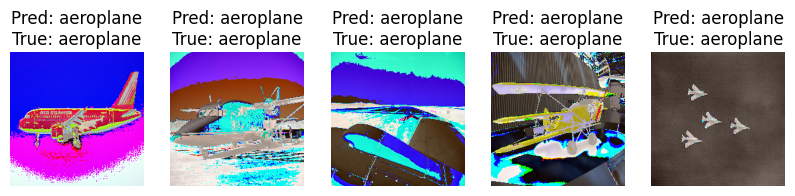

In [34]:
score_base_vgg = evaluate_model(model_base_vgg, vgg_test_dataset, "VGG16", threshold_base_vgg)

In [35]:
model_base_vgg.save('model_base_vgg.keras')

## VGG Fine Tuning

In [36]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))

set_trainable = False
for layer in vgg_base.layers:
    if "block5" in layer.name:
        set_trainable = True
    layer.trainable = set_trainable

model_ft_vgg = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])
model_ft_vgg = build_model(model_ft_vgg)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,799,444 (56.46 MB)

 Trainable params: 7,164,180 (27.33 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [37]:
history_ft_vgg = train_model(model_ft_vgg, vgg_train_dataset, vgg_validation_dataset)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 65s 767ms/step - f1_score: 0.3454 - loss: 8.1708 - mAP: 0.2256 - perfect_accuracy: 0.0733 - precision: 0.3948 - recall: 0.3230 - val_f1_score: 0.3584 - val_loss: 0.2214 - val_mAP: 0.3174 - val_perfect_accuracy: 0.2118 - val_precision: 0.6296 - val_recall: 0.3206
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - f1_score: 0.3053 - loss: 0.2625 - mAP: 0.1997 - perfect_accuracy: 0.1600 - precision: 0.4950 - recall: 0.2495 - val_f1_score: 0.4797 - val_loss: 0.1603 - val_mAP: 0.4666 - val_perfect_accuracy: 0.2708 - val_precision: 0.8429 - val_recall: 0.3558
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 748ms/step - f1_score: 0.4489 - loss: 0.1772 - mAP: 0.3873 - perfect_accuracy: 0.2550 - precision: 0.7117 - recall: 0.3575 - val_f1_score: 0.5841 - val_loss: 0.1360 - val_mAP: 0.6013 - val_perfect_accuracy: 0.4227 - val_precision: 0.8130 - val_recall: 0.5316
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - f1_score: 0.5345 - loss: 0.1554 - mAP: 0.4973 - 

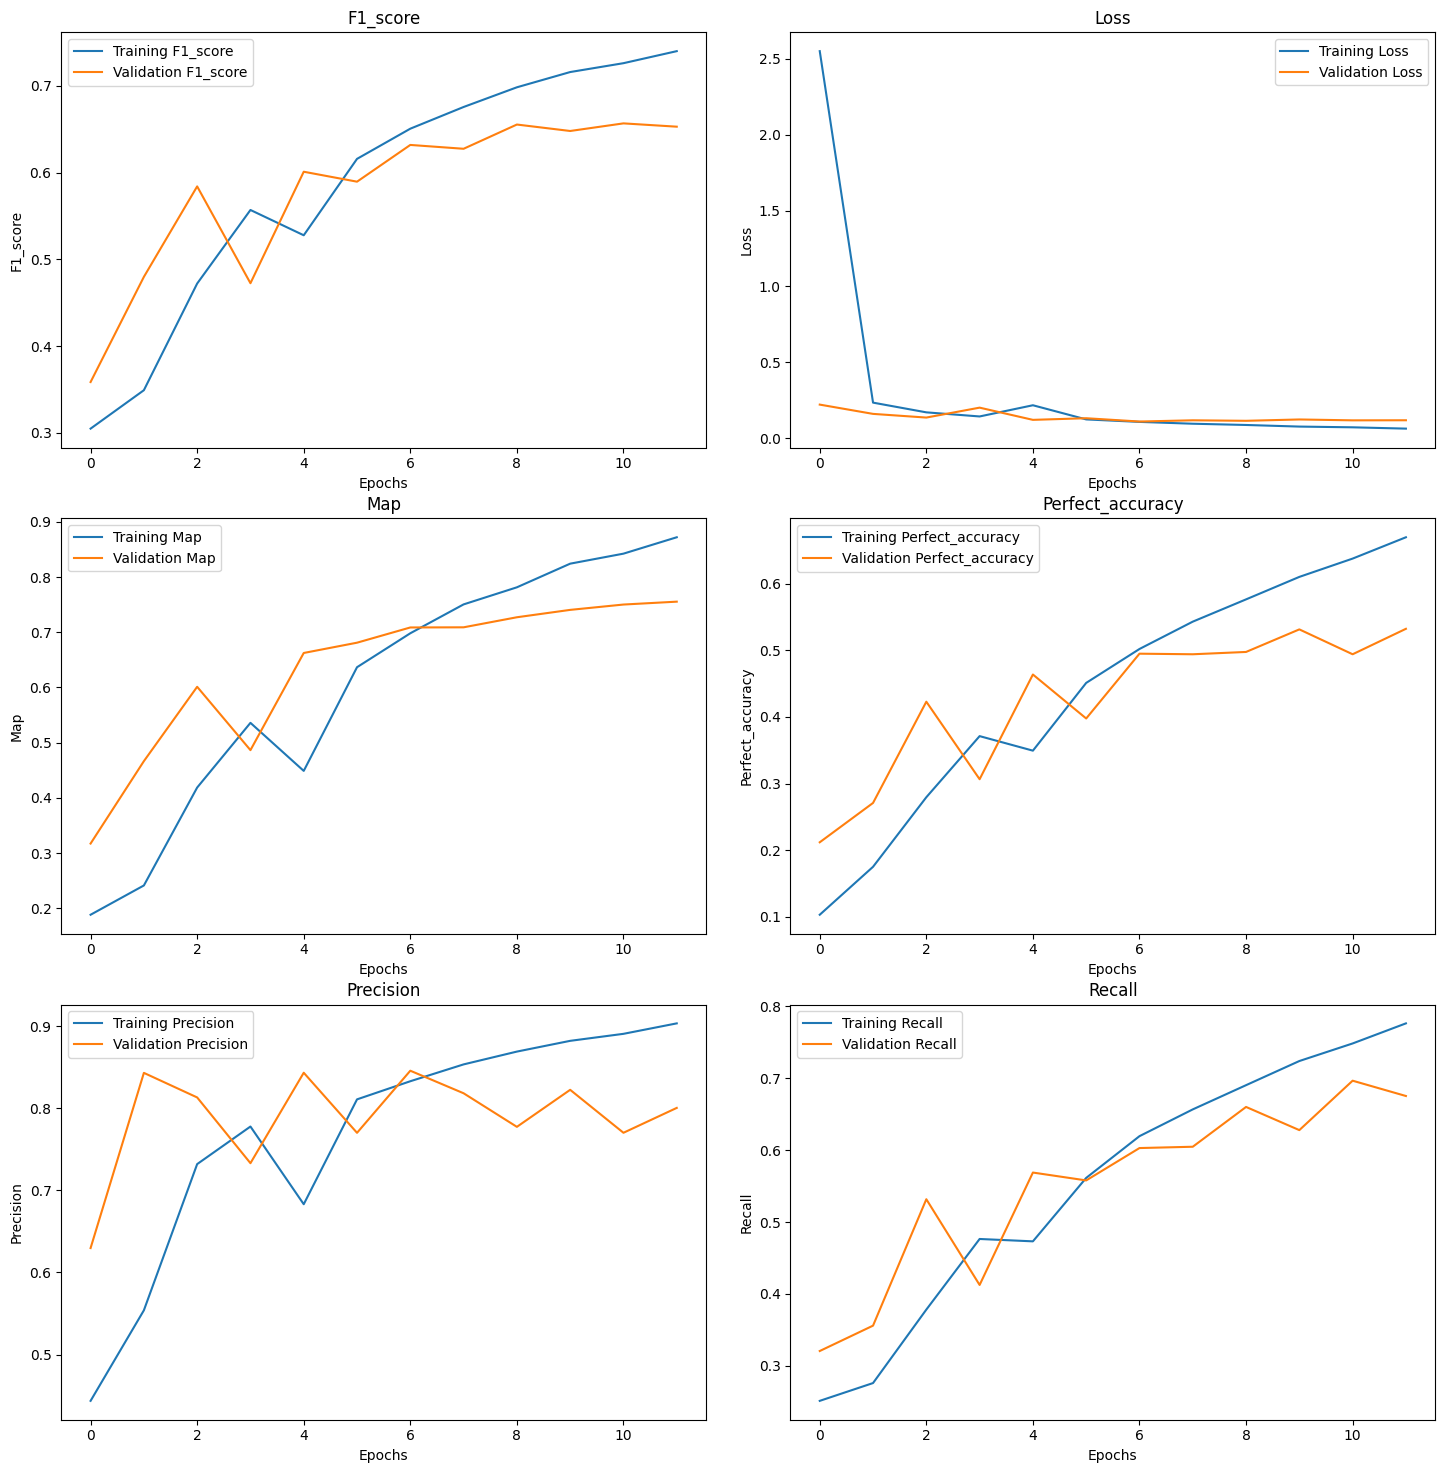

In [38]:
plot_history(history_ft_vgg)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step


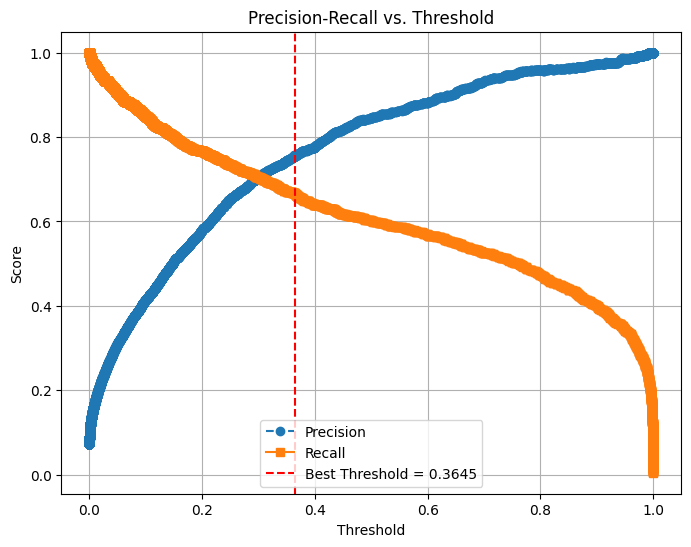

In [39]:
threshold_ft_vgg = validate_model(model_ft_vgg, vgg_validation_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step
Model: VGG16 with Fine Tuning
Binary Accuracy: 0.9572482705116272
Perfect Accuracy: 0.46875
mAP: 0.7155324220657349
F1 Score: 0.6725775599479675
Precision: 0.7331517934799194
Recall: 0.6449101567268372
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


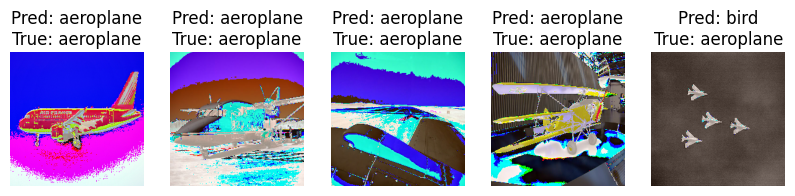

In [40]:
score_ft_vgg = evaluate_model(model_ft_vgg, vgg_test_dataset, "VGG16 with Fine Tuning", threshold_ft_vgg)

In [41]:
model_ft_vgg.save('model_ft_vgg.keras')

## MobileNet

In [42]:
mbnet_train_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "train.csv", TRAIN_IMAGE_DIR, mobilenet_preprocess_input)
mbnet_validation_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "validation.csv", VALIDATION_IMAGE_DIR, mobilenet_preprocess_input)
mbnet_test_dataset = create_tf_dataset(ANNOTATIONS_DATASET + "test.csv", TEST_IMAGE_DIR, mobilenet_preprocess_input)

In [43]:
MobileNet(weights='imagenet', include_top=True).summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [44]:
mbnet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
mbnet_base.trainable = False
model_base_mbnet = models.Sequential([
    mbnet_base,
    layers.GlobalAveragePooling2D(keepdims=True),
    layers.Dropout(0.5),
    layers.Conv2D(20, (1, 1), padding="same"),
    layers.Reshape((20,)),
    layers.Activation('sigmoid')
])
model_base_mbnet = build_model(model_base_mbnet)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1, 1, 1024)          │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 1, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 1, 20)            │          20,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,249,364 (12.40 MB)

 Trainable params: 20,500 (80.08 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [45]:
history_base_mbnet = train_model(model_base_mbnet, mbnet_train_dataset, mbnet_validation_dataset)

Epoch 1/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 45s 420ms/step - f1_score: 0.3640 - loss: 0.3316 - mAP: 0.2878 - perfect_accuracy: 0.0801 - precision: 0.3997 - recall: 0.3375 - val_f1_score: 0.6251 - val_loss: 0.1239 - val_mAP: 0.6449 - val_perfect_accuracy: 0.3403 - val_precision: 0.9128 - val_recall: 0.4331
Epoch 2/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 32s 391ms/step - f1_score: 0.5507 - loss: 0.1471 - mAP: 0.5293 - perfect_accuracy: 0.3116 - precision: 0.7197 - recall: 0.4716 - val_f1_score: 0.6892 - val_loss: 0.0985 - val_mAP: 0.7483 - val_perfect_accuracy: 0.4861 - val_precision: 0.8911 - val_recall: 0.5973
Epoch 3/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 533ms/step - f1_score: 0.6311 - loss: 0.1191 - mAP: 0.6611 - perfect_accuracy: 0.4017 - precision: 0.7745 - recall: 0.5808 - val_f1_score: 0.7066 - val_loss: 0.0896 - val_mAP: 0.7806 - val_perfect_accuracy: 0.5382 - val_precision: 0.8999 - val_recall: 0.6454
Epoch 4/40
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 566ms/step - f1_score: 0.6599 - loss: 0.1089 - mAP: 0.7

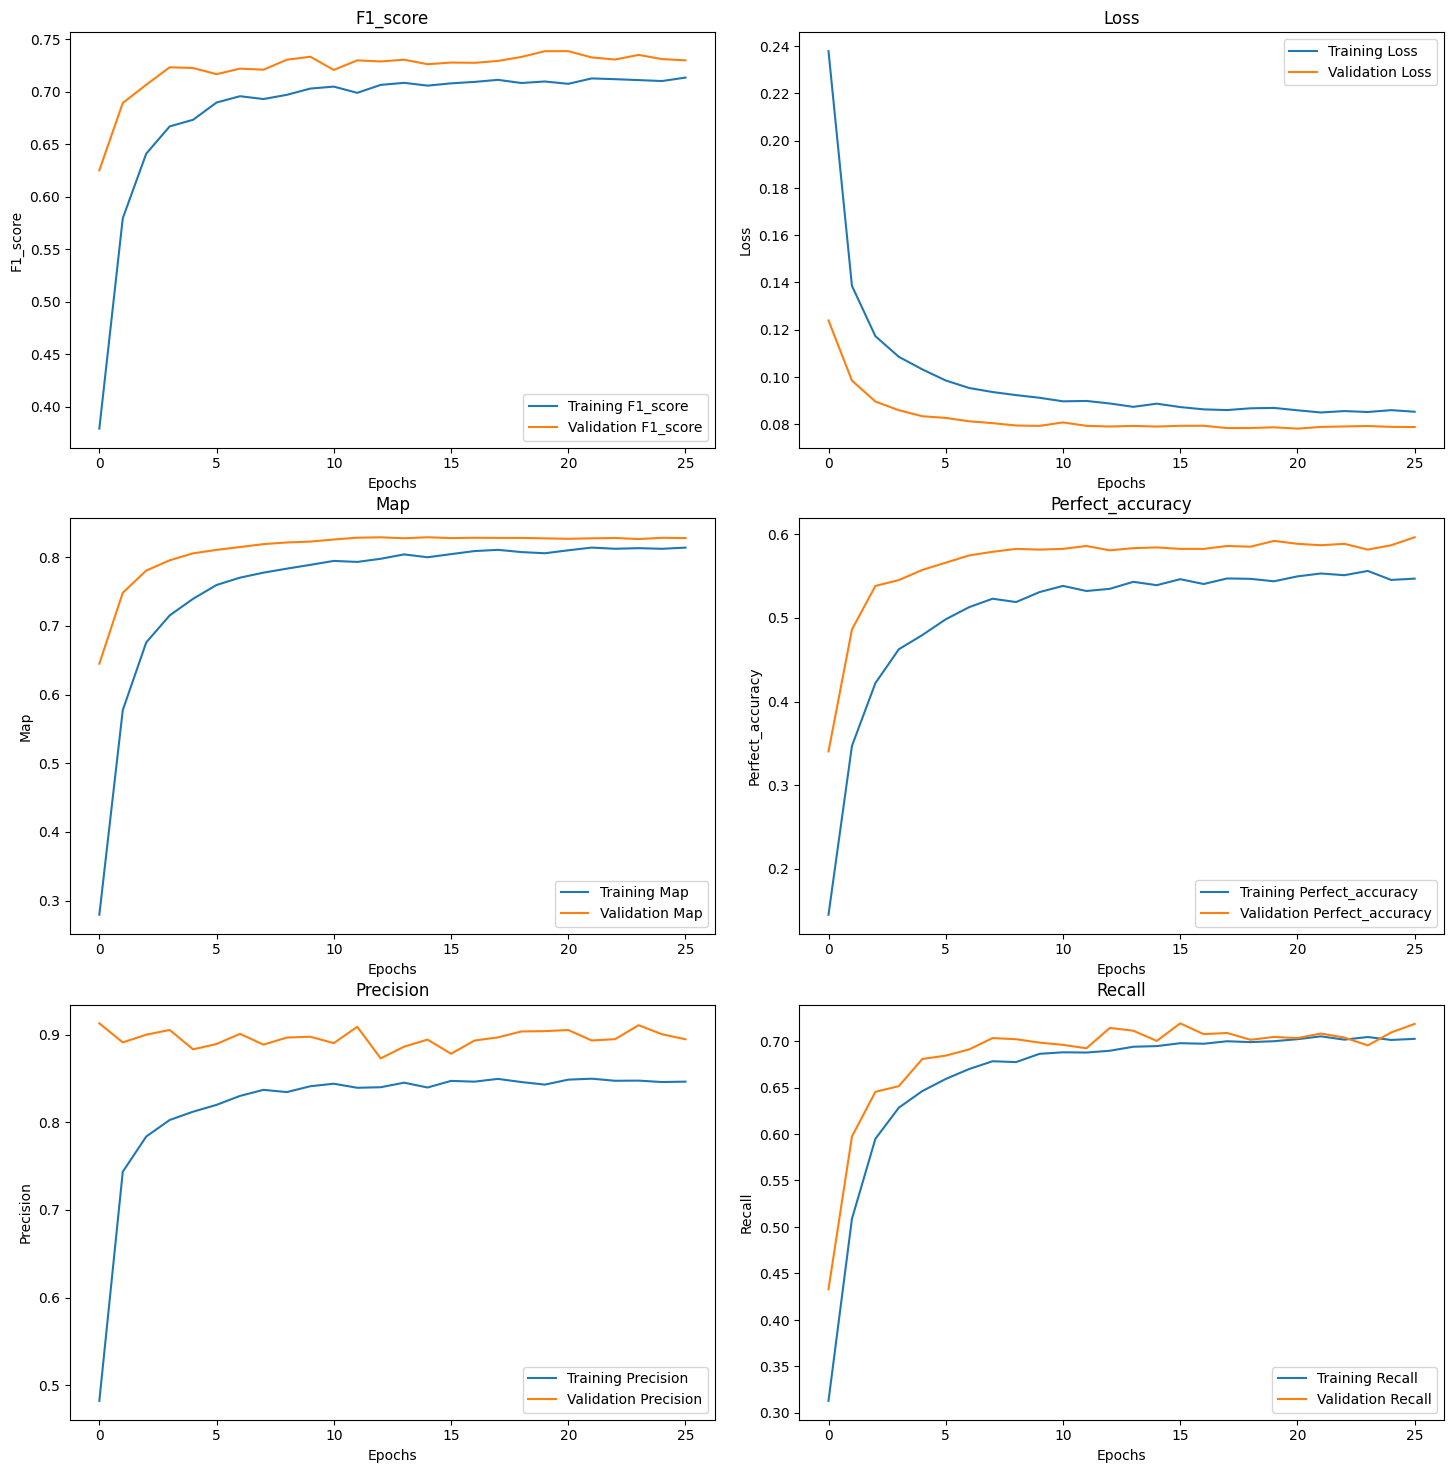

In [46]:
plot_history(history_base_mbnet)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


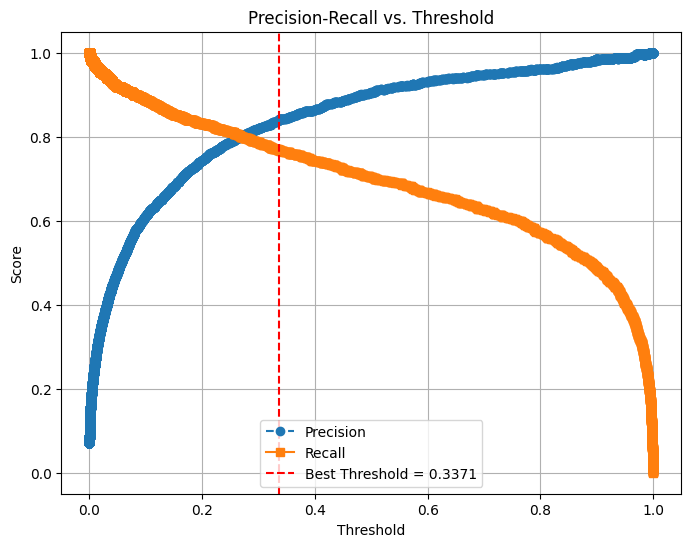

In [47]:
threshold_base_mbnet = validate_model(model_base_mbnet, mbnet_validation_dataset)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Model: MobileNet
Binary Accuracy: 0.9697916507720947
Perfect Accuracy: 0.5616319179534912
mAP: 0.824691891670227
F1 Score: 0.7760628461837769
Precision: 0.8225165605545044
Recall: 0.7437126040458679
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


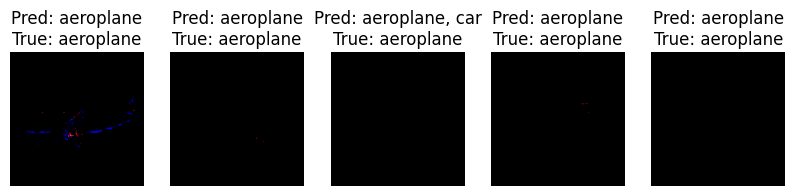

In [48]:
score_base_mbnet = evaluate_model(model_base_mbnet, mbnet_test_dataset, "MobileNet", threshold_base_mbnet)

In [49]:
model_base_mbnet.save('model_base_mbnet.keras')

# Comparison

In [51]:
scores = {
    'name': ['base_resnet', 'ft_resnet', 'base_vgg', 'ft_vgg', 'base_mbnet'],
    'binary_accuracy': [score_base_resnet['binary_accuracy'], score_ft_resnet['binary_accuracy'], score_base_vgg['binary_accuracy'], score_ft_vgg['binary_accuracy'], score_base_mbnet['binary_accuracy']],
    'perfect_accuracy': [score_base_resnet['perfect_accuracy'], score_ft_resnet['perfect_accuracy'], score_base_vgg['perfect_accuracy'], score_ft_vgg['perfect_accuracy'], score_base_mbnet['perfect_accuracy']],
    'map_metric': [score_base_resnet['map_metric'], score_ft_resnet['map_metric'], score_base_vgg['map_metric'], score_ft_vgg['map_metric'], score_base_mbnet['map_metric']],
    'f1_score': [score_base_resnet['f1_score'], score_ft_resnet['f1_score'], score_base_vgg['f1_score'], score_ft_vgg['f1_score'], score_base_mbnet['f1_score']],
    'precision': [score_base_resnet['precision'], score_ft_resnet['precision'], score_base_vgg['precision'], score_ft_vgg['precision'], score_base_mbnet['precision']],
    'recall': [score_base_resnet['recall'], score_ft_resnet['recall'], score_base_vgg['recall'], score_ft_vgg['recall'], score_base_mbnet['recall']]
}

In [53]:
df = pd.DataFrame(scores)
df

,name,binary_accuracy,perfect_accuracy,map_metric,f1_score,precision,recall
0,base_resnet,0.972309,0.603299,0.840852,0.792670,0.846774,0.754491
1,ft_resnet,0.971354,0.588542,0.835174,0.769488,0.883739,0.696407
2,base_vgg,0.966319,0.540799,0.793390,0.749130,0.801619,0.711377
3,ft_vgg,0.957248,0.468750,0.715532,0.672578,0.733152,0.644910
4,base_mbnet,0.969792,0.561632,0.824692,0.776063,0.822517,0.743713


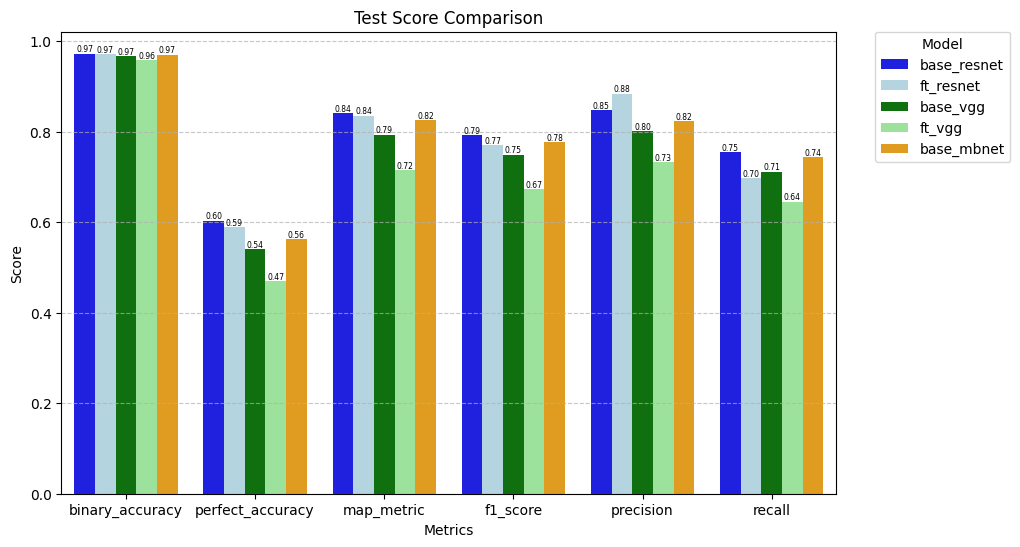

In [60]:
df_melted = df.melt(id_vars="name", var_name="metric", value_name="score")

palette = {
    'base_resnet': 'blue',
    'ft_resnet': 'lightblue',
    'base_vgg': 'green',
    'ft_vgg': 'lightgreen',
    'base_mbnet': 'orange'
}

# Creazione del grafico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="metric", y="score", hue="name", data=df_melted, palette=palette)

# Aggiungere i valori sopra le barre
for p in ax.patches:
  if p.get_height() > 0:  # Evita di stampare etichette per barre di altezza zero
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=5.5, color="black")

# Migliorare la leggibilità
plt.title("Test Score Comparison")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()
